## Perform bootstrapping ROC AUC method to determine if performing QC within our pipelines is important and improves performance 

In this method, we have trained two models; one with QC'd data and the other without QC'd data (more noise). 
We apply the models to their respective holdout dataset (e.g., QC'd model applied to QC'd data and no-QC model applied to no QC dataset).
We use bootstrapping, a method that repeatedly samples the dataset with replacement to create random subsets of the same size, where some cells might be duplicated or excluded, simulating variations in the population.
We calculate the ROC AUC for each subsample and plot as a histogram.

Our goal is to evaluate if QC is important enough to perform within our workflows where we see a higher performance in classification than if we performed no QC at all.

## Import libraries

In [1]:
import pathlib
import joblib
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind

import sys

sys.path.append("../../utils")
from training_utils import get_X_y_data
from roc_auc_utils import bootstrap_roc_auc

## Path for figure

In [2]:
figure_path = pathlib.Path("./figures/roc_auc_plots")
# make directory if it doesn't already exist
figure_path.mkdir(exist_ok=True)

## Load in encoder

In [3]:
# load in label encoder
le = load(
    pathlib.Path(
        "../0.train_logistic_regression/encoder_results/label_encoder_log_reg_fs_plate_4.joblib"
    )
)

## Load in non-QC model and no QC dataset

In [4]:
# Load the trained model
no_QC_model = joblib.load(
    pathlib.Path(
        "../0.train_logistic_regression/models/no_QC_models/log_reg_fs_plate_4_final_downsample_no_QC.joblib"
    )
)

# Load the feature-selected QC plate 4 (ensure it includes both features and labels)
plate_4_no_QC = pd.read_parquet(
    pathlib.Path(
        "../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected_no_QC.parquet"
    )
)

# Filter the test_data to only include rows where:
# - Metadata_heart_number == 7 and Metadata_treatment == "DMSO"
# - OR Metadata_heart_number == 29
holdout_no_QC_data = plate_4_no_QC[
    (
        (plate_4_no_QC["Metadata_heart_number"] == 7)
        & (plate_4_no_QC["Metadata_treatment"] == "DMSO")
    )
    | (plate_4_no_QC["Metadata_heart_number"] == 29)
]

# Load in X and y data from dataset
X, y = get_X_y_data(df=holdout_no_QC_data, label="Metadata_cell_type")

# Assign y classes to correct binary using label encoder results
y_binary_no_QC = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelNoQC = no_QC_model.predict_proba(X)[:, 1]

## Load in QC model and QC data

### Extract probabilities from the QC'd data using the QC model

In [5]:
# Load the trained model
QC_model = joblib.load(
    pathlib.Path(
        "../0.train_logistic_regression/models/log_reg_fs_plate_4_final_downsample.joblib"
    )
)

# Load the feature-selected QC plate 4 (ensure it includes both features and labels)
plate_4_QC = pd.read_parquet(
    pathlib.Path(
        "../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected.parquet"
    )
)

# Filter the test_data to only include rows where:
# - Metadata_heart_number == 7 and Metadata_treatment == "DMSO"
# - OR Metadata_heart_number == 29
holdout_QC_data = plate_4_QC[
    (
        (plate_4_QC["Metadata_heart_number"] == 7)
        & (plate_4_QC["Metadata_treatment"] == "DMSO")
    )
    | (plate_4_QC["Metadata_heart_number"] == 29)
]

# Load in X and y data from dataset
X, y = get_X_y_data(df=holdout_QC_data, label="Metadata_cell_type")

# Assign y classes to correct binary using label encoder results
y_binary_QC = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelQC = QC_model.predict_proba(X)[:, 1]

## Calculate the ROC AUC score from applying the respective holdout datasets to each model

In [6]:
# Calculate ROC AUC
aucNoQC = roc_auc_score(y_binary_no_QC, y_probs_modelNoQC)
aucQC = roc_auc_score(y_binary_QC, y_probs_modelQC)

print(f"AUC Model 1: {aucNoQC}")
print(f"AUC Model 2: {aucQC}")

AUC Model 1: 0.9053365172047568
AUC Model 2: 0.9288569897636957


## Apply bootstrap ROC function and perform a t-test to determine significant difference between distributions

In [7]:
# No QC model
scores_model1 = bootstrap_roc_auc(y_binary_no_QC, y_probs_modelNoQC)

# QC model
scores_model2 = bootstrap_roc_auc(y_binary_QC, y_probs_modelQC)

# Compare distributions
t_stat, p_value = ttest_ind(scores_model1, scores_model2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -103.65415669001037, P-value: 0.0


In [8]:
print(f"Mean ROC AUC for Model No-QC: {np.mean(scores_model1)}")
print(f"Mean ROC AUC for Model QC: {np.mean(scores_model2)}")

Mean ROC AUC for Model No-QC: 0.9052309223453695
Mean ROC AUC for Model QC: 0.9286980267529561


## Create histogram plot with the AUC ROC bootstrap distributions

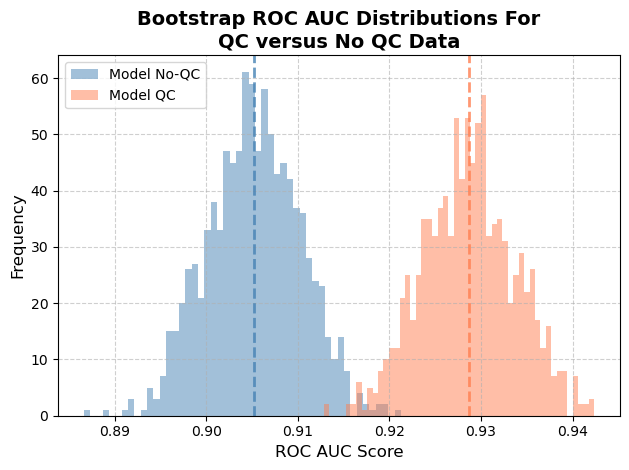

In [9]:
# Define darker colors for the mean lines
darker_steelblue = mcolors.to_rgba("steelblue", 0.8)
darker_coral = mcolors.to_rgba("coral", 0.8)

plt.hist(scores_model1, bins=50, alpha=0.5, label="Model No-QC", color="steelblue")
plt.hist(scores_model2, bins=50, alpha=0.5, label="Model QC", color="coral")

# Add vertical lines for the means
plt.axvline(
    np.mean(scores_model1),
    color=darker_steelblue,
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(scores_model2),
    color=darker_coral,
    linestyle="dashed",
    linewidth=2,
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("ROC AUC Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Bootstrap ROC AUC Distributions For\nQC versus No QC Data", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# save figure
plt.savefig(f"{figure_path}/bootstrap_ROC_AUC_QC_versus_no_QC.png", dpi=600)

plt.show()